## Initialising and connecting to DB

In [1]:
import sqlalchemy as sqla
import sys
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Chose the DB
db_input_2021 = input ("What database should we use?\n\n") #insert database name (see sqla for details on format)


# Create the sqlalchemy engine
db_engine_2021 = sqla.create_engine(db_input_2021) #is taken by pd.read_sql_query function later on

# Test connection
try:
    db_connection = db_engine_2021.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

In [3]:
# Chose the DB
db_input_2020 = input ("What database should we use?\n\n") 

# Create the sqlalchemy engine
db_engine_2020 = sqla.create_engine(db_input_2020) 

# Test connection
try:
    db_connection = db_engine_2020.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

# RegBL data from scraping

In [ ]:
# List of EGIDs from merged_egid_intersect: we have SATOM measurements for it

egid_df = pd.read_sql_query("SELECT DISTINCT EGID FROM city.merged_egid_intersect", db_engine_2021).dropna()
niter = egid_df.shape[0]

#Initiating storage for the scrapping results: empty Dataframe with default values
data = {"EGID": np.repeat(0,niter), "GBAUP": np.repeat(0,niter), "GBAUJ": np.repeat(0,niter),"GKLAS": np.repeat(0,niter), "GKAT": np.repeat(0,niter), "E": np.repeat(0,niter), "N": np.repeat(0,niter), "gastw": np.repeat(0,niter)}
data_df = pd.DataFrame(data)

In [ ]:
# List of EGIDs from merged_egid_intersect: we have SATOM measurements for it

egid_df = pd.read_sql_query("SELECT DISTINCT EGID FROM city.merged_egid_intersect", db_engine_2021).dropna()
niter = egid_df.shape[0]

#Initiating storage for the scrapping results: empty Dataframe with default values
data = {"EGID": np.repeat(0,niter), "GBAUP": np.repeat(0,niter), "GBAUJ": np.repeat(0,niter),"GKLAS": np.repeat(0,niter), "GKAT": np.repeat(0,niter), "E": np.repeat(0,niter), "N": np.repeat(0,niter), "gastw": np.repeat(0,niter)}
data_df = pd.DataFrame(data)# List of EGIDs from merged_egid_intersect: we have SATOM measurements for it

egid_df = pd.read_sql_query("SELECT DISTINCT EGID FROM city.merged_egid_intersect", db_engine_2021).dropna()
niter = egid_df.shape[0]

#Initiating storage for the scrapping results: empty Dataframe with default values
data = {"EGID": np.repeat(0,niter), "GBAUP": np.repeat(0,niter), "GBAUJ": np.repeat(0,niter),"GKLAS": np.repeat(0,niter), "GKAT": np.repeat(0,niter), "E": np.repeat(0,niter), "N": np.repeat(0,niter), "gastw": np.repeat(0,niter)}
data_df = pd.DataFrame(data)

In [ ]:
"""Instead if scraping each time, save data in csv table and upload back"""

"""Saving for future use. Uncomment to save table to computer"""
#data_df.to_csv('data_df')

""" Instead of scraping each time, can open csv form computer again"""
#data_path = 'data_df' #Make sure the data_df has been saved to the current working directory
#data_df = pd.read_csv(data_path, index_col=0) # open csv

# Geometry data

In [26]:
envelope = gpd.read_postgis(
        "SELECT surf.geometry AS geometry, thema.objectclass_id AS class_id, REGBL.egid AS egid, surf.cityobject_id AS cityobject_id, construction.constr_id as composite_id " #keep space before quote
        "FROM city.regbl_data REGBL "
        #"FROM citydb.cross_reference cros "
        "LEFT JOIN citydb.cross_reference cros ON cros.egid = REGBL.egid " #remove if doing whole area building_root_id [egid] satom (root_id)
        "JOIN citydb.building build ON build.building_root_id = cros.building_root_id " # [building_root_id] egid satom root_id (building_id objectclass_id building_parent_id)
        #"JOIN citydb.building build ON build.building_root_id = cros.building_root_id AND cros.egid = 190056978 "
        "LEFT JOIN citydb.thematic_surface thema ON thema.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id (thematic_surface_id objeclass_id building_id lod2_multisurface_id)
        "LEFT JOIN citydb.building_installation install ON install.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id (thema.objectclass_id lod2_brep_id)
        "JOIN citydb.surface_geometry surf ON (surf.root_id = thema.lod2_multi_surface_id OR surf.root_id = install.lod2_brep_id) AND surf.geometry IS NOT NULL " # OR surf.root_id = install.lod2_brep_id OR zone.root_id = surf.root_id #remove OR shade.root_id = surf.root_id if doing without shading surfaces
        # building_root_id egid satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id [lod2_multisurface_id] thema.objectclass_id [lod2_brep_id] (geometry parent_id)
        #"LEFT JOIN city.regbl_data rbl ON rbl.egid = cros.egid "  # building_root_id [egid] satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id thema.objectclass_id lod2_brep_id geometry parent_id (construction_period)
        "LEFT JOIN citydb.nrg8_cityobj_to_constr construction ON surf.cityobject_id = construction.cityobject_id",
        #"LEFT JOIN surfaces_data.default_composites comp ON comp.class_id = thema.objectclass_id AND rbl.construction_year BETWEEN comp.period_start AND comp.period_end",
        db_engine_2021, geom_col='geometry')

envelope = envelope.dropna(subset=['composite_id'])
envelope = envelope.dropna(subset=['geometry'])
envelope = envelope.drop_duplicates(subset=['geometry'])
envelope = envelope.drop(["composite_id"], axis=1)

#Keep floors objid =35
envelope = envelope[envelope["class_id"]==35]

envelope["geometry"] = envelope["geometry"].area

floor_areas = envelope.groupby(['egid']).sum()
floor_areas

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,geometry,class_id,cityobject_id
egid,,,
923868,110.230510,175.0,193390
923874,113.495075,2450.0,2632490
923909,109.844431,70.0,73758
923912,18.353558,105.0,87018
923913,48.491940,70.0,62902
...,...,...,...
191649872,32.174796,350.0,549982
191652312,28.804608,105.0,169635
191696052,19.171948,175.0,330875


In [27]:
# Calculating building volume

vol_df = pd.merge(floor_areas, data_df, left_on="egid", right_on="EGID",how="left")
vol_df = vol_df.dropna(subset=["EGID", "GBAUP", "GKLAS", "GKAT", "gastw"])
vol_df["volume"] = np.multiply(vol_df["geometry"],vol_df["gastw"]*4) # Assume that each floor is 4m
input_df = vol_df
input_df

,geometry,class_id,cityobject_id,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw,volume
0,110.230510,175.0,193390,923868.0,8012.0,NaN,1110.0,1020.0,560789.8,127748.5,2.0,881.844080
2,109.844431,70.0,73758,923909.0,8015.0,NaN,1110.0,1020.0,561157.8,127489.8,3.0,1318.133166
3,18.353558,105.0,87018,923912.0,8013.0,NaN,1110.0,1030.0,561256.0,127250.7,1.0,73.414232
9,256.916107,2730.0,2304354,923962.0,8015.0,NaN,1122.0,1020.0,560732.4,125678.1,3.0,3082.993290
11,96.441709,140.0,140748,923971.0,8011.0,NaN,1122.0,1030.0,560529.9,125410.6,3.0,1157.300508
...,...,...,...,...,...,...,...,...,...,...,...,...
543,123.992696,210.0,336564,191579561.0,8023.0,2017.0,1122.0,1020.0,562641.4,122215.3,6.0,2975.824692
545,40.287417,105.0,205455,191621572.0,8016.0,1985.0,1110.0,1030.0,562070.3,122726.3,2.0,322.299332
551,32.174796,350.0,549982,191649872.0,8012.0,1919.0,1110.0,1020.0,562088.4,122254.3,3.0,386.097558
553,19.171948,175.0,330875,191696052.0,8023.0,2019.0,1122.0,1020.0,562044.4,122260.3,5.0,383.438960


# Meteo data

In [28]:
meteo_path = 'Aigle_MeteoSchweiz_2019_v2.cli'
# Take the climate file and remove the header
# keep only columns woth data
meteo_df = pd.read_csv(meteo_path, delimiter=' ')
meteo_df = meteo_df.drop(["FF", "DD", "RH", "N"], axis=1)

In [29]:
meteo_df

,dm,m,h,G_Dh,G_h,Ta,Ts,RR
0,1,1,1,0.2,2.00,0.84,4.40,0.0
1,1,1,2,0.0,2.00,0.72,4.33,0.0
2,1,1,3,0.0,2.00,0.45,4.30,0.0
3,1,1,4,0.0,1.83,0.13,4.30,0.0
4,1,1,5,0.0,2.00,0.45,4.23,0.0
...,...,...,...,...,...,...,...,...
8755,31,12,20,0.0,2.00,0.83,4.30,0.0
8756,31,12,21,0.0,2.00,0.70,4.30,0.0
8757,31,12,22,0.0,2.00,0.12,4.30,0.0
8758,31,12,23,0.0,2.00,0.27,4.30,0.0


# Output Data

In [30]:
"""# Download output for training (results of SATOM measurements)
satom_df = pd.read_sql_query("SELECT gmlid, values_array FROM citydb.nrg8_time_series WHERE time_interval_unit='year'", db_engine_2021)
satom_df['values_array'] = satom_df['values_array'].apply(pd.Series)
merged_egid_intersect = pd.read_sql_query("SELECT gmlid, egid FROM city.merged_egid_intersect", db_engine_2021)
db_connection.close()

output_df = pd.merge(satom_df, merged_egid_intersect, on="gmlid", how="right").dropna().drop_duplicates(["egid"])
output_df
#contains gmlid, annual energy cons, egid
"""

"""Using locally saved data """
time_expanded = pd.read_csv('satom_output.csv', index_col=0)

# Add EGID to gmlid 
merged_egid_intersect = pd.read_sql_query("SELECT gmlid, ogr_fid, EGID FROM city.merged_egid_intersect", db_engine_2021)
output_df = pd.merge(time_expanded, merged_egid_intersect[["gmlid", "egid"]], on="gmlid", how="left")
output_df = output_df.dropna()
output_df = output_df.drop(["gmlid"], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
output_df

,timestamp,energy,year,month,hour,weekday,day_nbr,dayofyr,egid
0,2019-11-05 10:05:12,0.0,2019,11,10,1,5,309,925189.0
1,2019-11-05 10:05:12,0.0,2019,11,10,1,5,309,925189.0
2,2019-11-05 10:05:12,0.0,2019,11,10,1,5,309,925189.0
3,2019-11-05 10:05:12,0.0,2019,11,10,1,5,309,925189.0
4,2019-11-05 10:05:12,0.0,2019,11,10,1,5,309,925189.0
...,...,...,...,...,...,...,...,...,...
75766741,2019-12-31 15:28:00,0.0,2019,12,15,1,31,365,926281.0
75766743,2019-12-31 17:39:36,0.0,2019,12,17,1,31,365,926281.0
75766745,2019-12-31 18:53:43,0.0,2019,12,18,1,31,365,926281.0
75766747,2019-12-31 21:05:15,0.0,2019,12,21,1,31,365,926281.0


# Linking input & output

In [32]:
input_output_df = pd.merge(input_df, output_df, left_on="EGID", right_on="egid", how="inner").drop(["geometry", "class_id", "cityobject_id", "EGID", "E", "N"], axis=1)
input_output_df = input_output_df.drop_duplicates(keep='first')

In [33]:
input_output_df

,GBAUP,GBAUJ,GKLAS,GKAT,gastw,volume,timestamp,energy,year,month,hour,weekday,day_nbr,dayofyr,egid
0,8012.0,NaN,1110.0,1020.0,2.0,881.844080,2019-08-27 11:41:10,0.0,2019,8,11,1,27,239,923868.0
1,8012.0,NaN,1110.0,1020.0,2.0,881.844080,2019-09-23 12:43:58,0.0,2019,9,12,0,23,266,923868.0
2,8012.0,NaN,1110.0,1020.0,2.0,881.844080,2019-09-23 16:21:17,0.0,2019,9,16,0,23,266,923868.0
3,8012.0,NaN,1110.0,1020.0,2.0,881.844080,2019-09-23 17:59:14,0.0,2019,9,17,0,23,266,923868.0
4,8012.0,NaN,1110.0,1020.0,2.0,881.844080,2019-09-23 19:38:46,0.0,2019,9,19,0,23,266,923868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064725,8019.0,1999.0,1110.0,1030.0,3.0,499.864866,2019-12-31 15:28:00,0.0,2019,12,15,1,31,365,191761197.0
3064726,8019.0,1999.0,1110.0,1030.0,3.0,499.864866,2019-12-31 17:39:36,0.0,2019,12,17,1,31,365,191761197.0
3064727,8019.0,1999.0,1110.0,1030.0,3.0,499.864866,2019-12-31 18:53:43,0.0,2019,12,18,1,31,365,191761197.0
3064728,8019.0,1999.0,1110.0,1030.0,3.0,499.864866,2019-12-31 21:05:15,0.0,2019,12,21,1,31,365,191761197.0


# Plotting data: all data

In [34]:
# Get unique info on buildings
buildings = input_output_df.drop_duplicates(["egid"], keep='first')

In [35]:
len(buildings)

261

<AxesSubplot:xlabel='volume', ylabel='Count'>

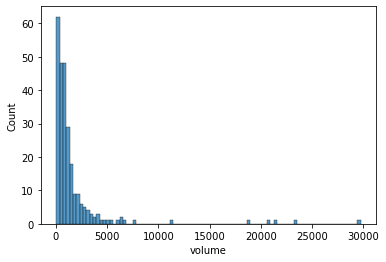

In [36]:
sns.histplot(buildings['volume'])

<AxesSubplot:xlabel='GKAT', ylabel='Count'>

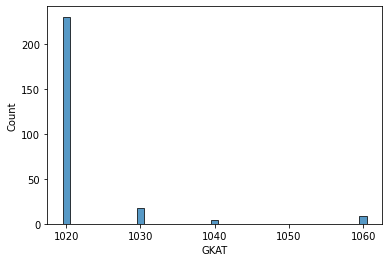

In [37]:
sns.histplot(buildings['GKAT'], discrete=True)

<AxesSubplot:xlabel='GKLAS', ylabel='Count'>

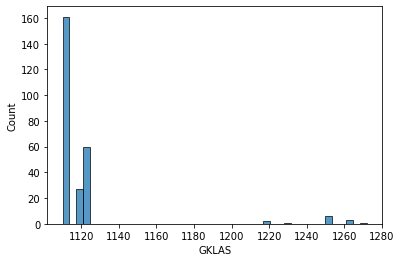

In [38]:
sns.histplot(buildings['GKLAS'])

<AxesSubplot:xlabel='GBAUP', ylabel='Count'>

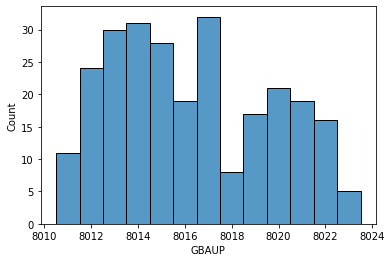

In [39]:
sns.histplot(buildings['GBAUP'], discrete =True)

# Plotting data: annual data

In [13]:
vol_df = pd.merge(floor_areas, data_df, left_on="egid", right_on="EGID",how="left")
vol_df

,geometry,class_id,cityobject_id,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw
0,110.230510,175.0,193390,923868.0,8012.0,NaN,1110.0,1020.0,560789.8,127748.5,2.0
1,113.495075,2450.0,2632490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,109.844431,70.0,73758,923909.0,8015.0,NaN,1110.0,1020.0,561157.8,127489.8,3.0
3,18.353558,105.0,87018,923912.0,8013.0,NaN,1110.0,1030.0,561256.0,127250.7,1.0
4,48.491940,70.0,62902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
551,32.174796,350.0,549982,191649872.0,8012.0,1919.0,1110.0,1020.0,562088.4,122254.3,3.0
552,28.804608,105.0,169635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,19.171948,175.0,330875,191696052.0,8023.0,2019.0,1122.0,1020.0,562044.4,122260.3,5.0
554,41.655406,175.0,267900,191761197.0,8019.0,1999.0,1110.0,1030.0,562180.0,122455.1,3.0


In [50]:
"""Using locally saved data"""
# Download output for training (results of SATOM measurements)
output_df = pd.read_csv("yearly.csv", index_col=False).drop_duplicates(["ogr_fid"])
output_df = output_df[["annual_energy", "gmlid", "ogr_fid", "egid"]]
output_df = output_df.dropna()
output_df = output_df.drop_duplicates(["egid"])
output_df = output_df[output_df["annual_energy"] !=0] #remove when always 0

In [51]:
input_output_df_annual = pd.merge(vol_df, output_df, left_on="EGID", right_on="egid", how="inner")
input_output_df_annual.head(5)

,geometry,class_id,cityobject_id,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw,volume,annual_energy,gmlid,ogr_fid,egid
0,96.557143,210.0,386550,925140.0,8012.0,NaN,1122.0,1020.0,562305.0,122432.1,3.0,1158.685716,160963.0,_23A25652-1CD9-4457-AE1E-A53A07D06CA5,921.0,925140.0
1,83.105961,175.0,372890,925148.0,8016.0,NaN,1122.0,1020.0,562609.0,122555.1,6.0,1994.543052,251120.0,_AE0F7597-0F55-429D-82ED-0E74A3EE5FC1,904.0,925148.0
2,60.614135,140.0,290754,925196.0,8013.0,NaN,1121.0,1020.0,562619.0,122718.1,3.0,727.369620,433539.0,_4215DBFF-93D9-44F6-9CED-C534ED975C98,784.0,925196.0
3,76.565648,70.0,124586,925210.0,8013.0,NaN,1122.0,1030.0,562303.0,122597.1,9.0,2756.363328,331283.0,UUID_3e006c16-cc80-40de-a7bf-8ae2b45d6ef0,990.0,925210.0
4,154.219087,105.0,174351,925229.0,8014.0,NaN,1122.0,1030.0,562504.3,122700.3,6.0,3701.258076,4549590.0,UUID_0a5fa891-110f-436b-864f-7f0741855bdf,787.0,925229.0


In [52]:
len(input_output_df_annual)

33

<AxesSubplot:xlabel='geometry', ylabel='Count'>

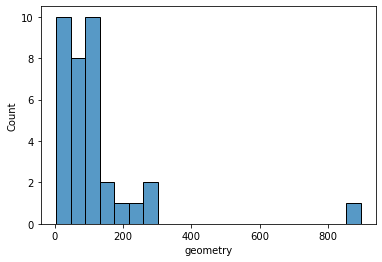

In [16]:
sns.histplot(input_output_df_annual['geometry'])

<AxesSubplot:xlabel='GBAUP', ylabel='Count'>

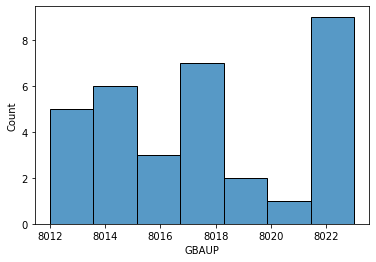

In [17]:
sns.histplot(input_output_df_annual['GBAUP'])

<AxesSubplot:xlabel='GKAT', ylabel='Count'>

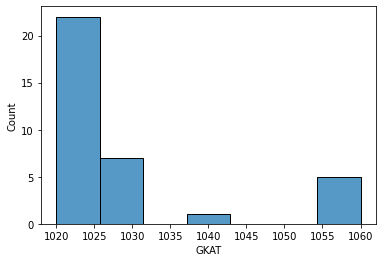

In [18]:
sns.histplot(input_output_df_annual['GKAT'])

<AxesSubplot:xlabel='GKLAS', ylabel='Count'>

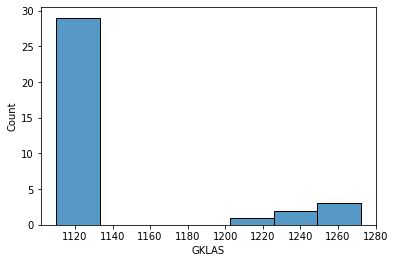

In [19]:
sns.histplot(input_output_df_annual['GKLAS'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='geometry', ylabel='annual_energy'>

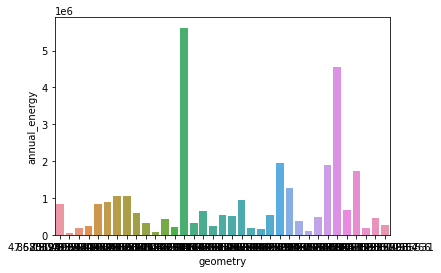

In [67]:
sns.barplot(input_output_df_annual['geometry'],input_output_df_annual['annual_energy'] )

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Annual energy demand [Wh]')

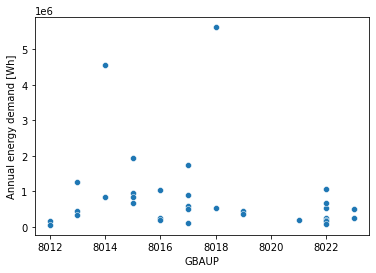

In [42]:
sns.scatterplot(input_output_df_annual['GBAUP'], input_output_df_annual['annual_energy'])
plt.xlabel("GBAUP")
plt.ylabel("Annual energy demand [Wh]")